In [1]:
import math
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset as DT 
from torch.utils.data import DataLoader as DL
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import warnings
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
def read_lexicons_files(lex_files):
    with open(lex_files, "r", encoding = 'utf-8') as ff:
        data = ff.readlines()
#     basic cleaning of data
    data = [dt.strip().split('\t') for dt in data]
    lexicon_dict = {}
    for v in data:
        if len(v) == 3:
            key = v[0]
            value = {'-ve': float(v[1]), '+ve': float(v[2])}
            lexicon_dict[key] = value

    return lexicon_dict

In [3]:
def load_data(tfile, lfile):
    with open(tfile, 'r',encoding = 'utf-8') as n:
        tweetsandtext = n.readlines()

    with open(lfile, 'r',encoding = 'utf-8') as n:
        labelsforencoding = n.readlines()

    return tweetsandtext, labelsforencoding

In [4]:
def data_clean_tweets(t):
    
    t = re.sub(r'http\S+|www\S+|https\S+|\S+@\S+', '', t)
     # Remove numbers
    t = re.sub(r'\d+', '', t)
    t = re.sub('[^a-zA-Z0-9\s]', '', t)
    
    tz = word_tokenize(t)
    tz = [x.lower() for x in tz if x not in string.punctuation]
    sws = set(stopwords.words('english'))
    tz = [x for x in tz if x not in sws]
    st = PorterStemmer()
    tz = [st.stem(x) for x in tz]
    cleaned_text = ' '.join(tz)
    return cleaned_text

In [5]:
def get_feature(tweet, lexicons):
    # Split tweet into words
    words = tweet.split()
    
    # Count words in the tweet
    total_words = len(words)
    
    # Finding the longest word
    longest_word = max(words, key=len)
    
    # Set 12 features to the list
    feature_set = [0] * 12
    
    # Calculate lexicon scores for each word in the tweet
    for i, lex_dict in enumerate(lexicons[:9]):
        score = 0
        for word in words:
            sentiment_dict = lex_dict.get(word, {'-ve': 0, '+ve': 0})
            score += sentiment_dict['-ve'] + sentiment_dict['+ve']
        feature_set[i] = score
    
    # Log of the word count for the tweet
    if total_words > 0:
        feature_set[9] = math.log(total_words)
    else:
        feature_set[9] = 0
    
    # Log of length of longest word
    if longest_word:
        feature_set[10] = math.log(len(longest_word))
    else:
        feature_set[10] = 0
    
    # Count of words that have 5 characters or more
    long_word_count = sum([1 for word in words if len(word) >= 5])
    
    # Log of count of long words
    if long_word_count > 0:
        feature_set[11] = math.log(long_word_count)
    else:
        feature_set[11] = 0
    
    return feature_set

In [6]:
class SentimentDataset(DT):
    def __init__(self, feat, l):
        # Convert  to PyTorch tensors
        if not isinstance(features, tt):
            feat = tt(feat)
        if not isinstance(labels, tt):
            l = tt(l)
        
        self.feat = feat
        self.l = l

    def __len__(self):
        # Return length of dataset
        return len(self.feat)

    def __getitem__(self, index):
        # Checking if the index is in range
        assert index < len(self), "Index out of range"
        feat = self.feat[index]
        l = self.l[index]
        
        return feat, l

In [7]:
enc_type = 'utf-8'

In [8]:
all_lexicon_files = ['3DS.tsv', '4chan.tsv', '2007scape.tsv', 'ACTrade.tsv', 
                 'amiugly.tsv', 'BabyBumps.tsv', 'baseball.tsv', 'canada.tsv', 
                 'CasualConversation.tsv', 'DarknetMarkets.tsv', 'darksouls.tsv', 'elderscrollsonline.tsv', 
                 'Eve.tsv', 'Fallout.tsv', 'fantasyfootball.tsv', 'GameDeals.tsv', 'gamegrumps.tsv', 'halo.tsv', 
                 'Homebrewing.tsv', 'IAmA.tsv', 'india.tsv', 'jailbreak.tsv', 'Jokes.tsv', 'KerbalSpaceProgram.tsv', 
                 'Keto.tsv', 'leagueoflegends.tsv', 'Libertarian.tsv', 'magicTCG.tsv', 'MakeupAddiction.tsv', 
                 'Naruto.tsv', 'nba.tsv', 'oculus.tsv', 'OkCupid.tsv', 'Parenting.tsv', 'pathofexile.tsv', 
                 'raisedbynarcissists.tsv', 'Random_Acts_Of_Amazon.tsv', 'science.tsv', 'Seattle.tsv', 
                 'TalesFromRetail.tsv', 'talesfromtechsupport.tsv', 'ultrahardcore.tsv', 'videos.tsv', 
                 'Warthunder.tsv', 'whowouldwin.tsv', 'xboxone.tsv', 'yugioh.tsv']

In [9]:
adj = "adjectives/2000.tsv"
freq = "adjectives/2000.tsv"
adjectives = read_lexicons_files(adj)
frequency = read_lexicons_files(freq)

In [10]:
lexicon_values = []
xz = {}
for i in all_lexicon_files:
    z = read_lexicons_files('subreddits/'+i)
    xz[i] = len(z)
    lexicon_values.append(z)

In [11]:
names = list(xz.keys())
values = list(xz.values())

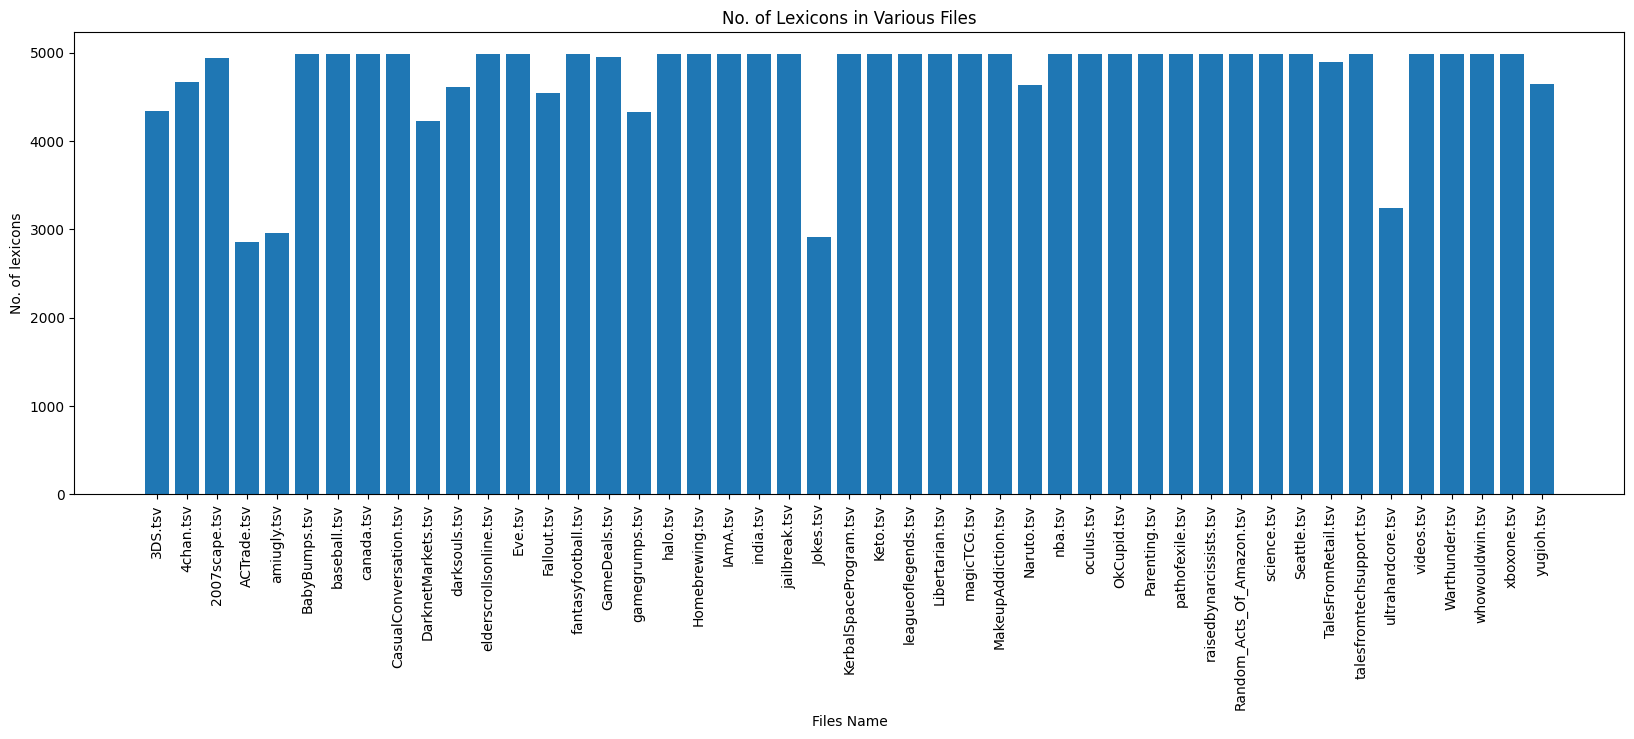

In [12]:
plt.figure(figsize=(20, 6))
plt.bar(names, values)
plt.xticks(rotation=90)
plt.xlabel('Files Name')
plt.ylabel('No. of lexicons')
plt.title('No. of Lexicons in Various Files')
plt.show()

In [13]:
combined = [adjectives, frequency] + lexicon_values 

In [14]:
train_text, train_labels = load_data('sentiment/train_text.txt', 'sentiment/train_labels.txt')
val_text, val_labels = load_data('sentiment/val_text.txt', 'sentiment/val_labels.txt')
test_text, test_labels = load_data('sentiment/test_text.txt', 'sentiment/test_labels.txt')

In [15]:
train_text = [data_clean_tweets(tweet) for tweet in train_text]
val_text = [data_clean_tweets(tweet) for tweet in val_text]
test_text = [data_clean_tweets(tweet) for tweet in test_text]

In [16]:
def get_embedding(tweet, model, size):
    words = tweet.split()
    vec = np.zeros(size)
    count = 0
    for word in words:
        try:
            vec += model.wv[word]
            count += 1
        except KeyError:
            pass
    if count != 0:
        vec /= count
    return vec
tt = torch.tensor

In [17]:
tokenized_tweets = [tweet.split() for tweet in train_text + val_text + test_text]

#Word2Vec model
word2vec_model = Word2Vec(tokenized_tweets, vector_size=300, window=5, min_count=1, workers=4)

In [18]:
# Encode labels
dts = torch.long
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
val_labels = encoder.transform(val_labels)
test_labels = encoder.transform(test_labels)

y_train = tt(train_labels, dtype=dts)
y_val = tt(val_labels, dtype=dts)
y_test = tt(test_labels, dtype=dts)


In [19]:
X_train_embed = np.array([get_embedding(tweet, word2vec_model, 300) for tweet in train_text])
X_val_embed = np.array([get_embedding(tweet, word2vec_model, 300) for tweet in val_text])
X_test_embed = np.array([get_embedding(tweet, word2vec_model, 300) for tweet in test_text])

# Combine train, validation, and test data
X_all = np.concatenate((X_train_embed, X_val_embed, X_test_embed), axis=0)
y_all = np.concatenate((y_train, y_val, y_test), axis=0)

In [20]:
class SentimentDataset(DT):
    def __init__(self, data, targets):
        # Checking if data and targets are of the same length
        assert len(data) == len(targets), "Data and targets must have the same length"
        
        # Convert data to tensors
        self.data = tt(data)
        self.targets = tt(targets)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # finding data and target at the given index
        data_point = self.data[index]
        target = self.targets[index]
        return data_point, target


In [21]:
class SentimentModel(nn.Module):
    def __init__(self, indim, hdim, odim):
        super(SentimentModel, self).__init__()
        self.leyar1 = nn.Linear(indim, hdim)
        self.activation = nn.ReLU()
        self.l2 = nn.Linear(hdim, odim)
        self.output_layer = nn.Softmax(dim=1)

    def forward(self, z):
        z = self.leyar1(z)
        z = self.activation(z)
        z = self.l2(z)
        z = self.output_layer(z)
        return z

In [22]:
input_size = 300
dty = torch.float32

data_train = SentimentDataset(tt(X_train_embed, dtype=dty), y_train)
data_val = SentimentDataset(tt(X_val_embed, dtype=dty), y_val)
data_test = SentimentDataset(tt(X_test_embed, dtype=dty), y_test)

load_train = DL(data_train, batch_size=64, shuffle=True)
load_val = DL(data_val, batch_size=64, shuffle=False)
load_test = DL(data_test, batch_size=64, shuffle=False)


In [23]:
hidden_size = 64
num_classes = 3
batch_size = 32
model = SentimentModel(input_size, hidden_size, num_classes)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
def train(model, X, y, criterion, optimizer, num_epochs):
    ds = torch.utils.data.TensorDataset(X, y)
    dataloader = DL(ds, batch_size=batch_size, shuffle=True)

    train_losses = []
    train_accuracies = []

    for e in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inp, lab in dataloader:
            optimizer.zero_grad()
            out = model(inp)
            loss = criterion(out, lab)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(out, 1)
            running_loss += loss.item() * inp.size(0)
            running_corrects += torch.sum(preds == lab.data)
            total_samples += inp.size(0)

        epoch_loss = running_loss / total_samples
        epoch_accuracy = running_corrects.double() / total_samples
        if (e + 1) % 25 == 0:
            print(f"Epoch {e+1}/{num_epochs} Loss: {epoch_loss:.6f} Accuracy: {epoch_accuracy:.6f}")
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy.item())

    return train_losses, train_accuracies


In [26]:
def validate(model, dataloader, criterion):
    model.eval()
    runLoss = 0.0

    with torch.no_grad():
        for ipnputs, lebles in dataloader:
            oput = model(ipnputs)
            lose = criterion(oput, lebles)
            runLoss += lose.item()

    return runLoss / len(dataloader)

In [27]:
def predict(model, X):
    model.eval()
    ds = torch.utils.data.TensorDataset(X)
    dloader = DL(ds, batch_size=batch_size, shuffle=False)
    
    pre = []
    with torch.no_grad():
        for inputs, in dloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            pre.extend(preds.tolist())
    return pre

In [28]:
num_epochs = 100

In [29]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


foldsCount = 5
kf = KFold(n_splits=foldsCount, shuffle=True, random_state=42)
fold_accuracies = []
fold_f1s = []

all_train_losses = []
all_train_accuracies = []

for fold, (ti, tei) in enumerate(kf.split(X_all, y_all)):
    X_train_fold = tt(X_all[ti], dtype=dty)
    y_train_fold = tt(y_all[ti], dtype=torch.long)
    X_test_fold = tt(X_all[tei], dtype=dty)
    y_test_fold = tt(y_all[tei], dtype=torch.long)
    
    # cross-validation folds data
    model_w2v = SentimentModel(input_size, hidden_size, num_classes)
    opti = optim.Adam(model_w2v.parameters(), lr=0.001)
    train_losses, train_accuracies = train(model_w2v, X_train_fold, y_train_fold, criterion, opti, num_epochs)
    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    
    # testing using testdata
    y_pred_fold = predict(model_w2v, X_test_fold)
    fold_confusion_matrix = confusion_matrix(y_test_fold, y_pred_fold)
    print()
    print(f"Confusion Matrix for Fold {fold+1}:\n{fold_confusion_matrix}\n")
    # Finding accuracy
    fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
    fold_f1 = f1_score(y_test_fold, y_pred_fold, average='weighted')
    fold_accuracies.append(fold_accuracy)
    fold_f1s.append(fold_f1)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.6f}, F1 Score: {fold_f1:.6f}")
    print()
    print()

average_accuracy = sum(fold_accuracies) / foldsCount
print()
print()
print(f"Average Accuracy: ",average_accuracy*100)
average_f1 = sum(fold_f1s) / foldsCount
print("Average F1-score:",average_f1*100)

Epoch 25/100 Loss: 0.948883 Accuracy: 0.578622
Epoch 50/100 Loss: 0.941048 Accuracy: 0.589891
Epoch 75/100 Loss: 0.935682 Accuracy: 0.596924
Epoch 100/100 Loss: 0.931273 Accuracy: 0.602663

Confusion Matrix for Fold 1:
[[ 623 1218  428]
 [ 451 3749 1280]
 [ 115 1526 2590]]

Fold 1 Accuracy: 0.581135, F1 Score: 0.569202


Epoch 25/100 Loss: 0.951017 Accuracy: 0.577474
Epoch 50/100 Loss: 0.943405 Accuracy: 0.585864
Epoch 75/100 Loss: 0.936826 Accuracy: 0.594691
Epoch 100/100 Loss: 0.933241 Accuracy: 0.600367

Confusion Matrix for Fold 2:
[[ 610 1280  374]
 [ 434 3968 1089]
 [ 102 1711 2412]]

Fold 2 Accuracy: 0.583472, F1 Score: 0.569812


Epoch 25/100 Loss: 0.952047 Accuracy: 0.575763
Epoch 50/100 Loss: 0.943150 Accuracy: 0.586344
Epoch 75/100 Loss: 0.938528 Accuracy: 0.593084
Epoch 100/100 Loss: 0.933856 Accuracy: 0.600388

Confusion Matrix for Fold 3:
[[ 617 1373  253]
 [ 445 4349  744]
 [ 126 2007 2066]]

Fold 3 Accuracy: 0.586978, F1 Score: 0.569840


Epoch 25/100 Loss: 0.951324 Acc

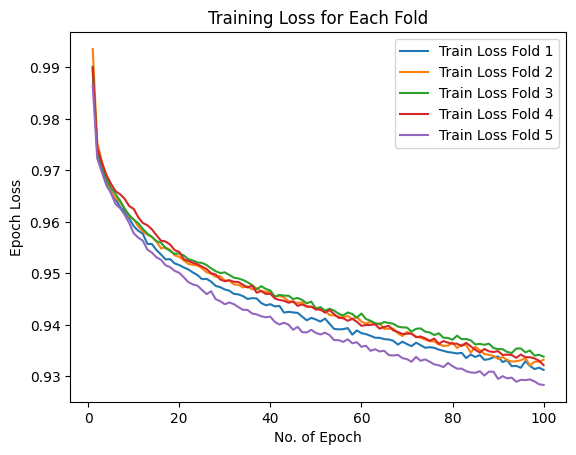

In [30]:
for fold, train_losses in enumerate(all_train_losses):
    plt.plot(range(1, num_epochs+1), train_losses, label=f'Train Loss Fold {fold+1}')

plt.title('Training Loss for Each Fold')
plt.xlabel('No. of Epoch')
plt.ylabel('Epoch Loss')
plt.legend()
plt.show()

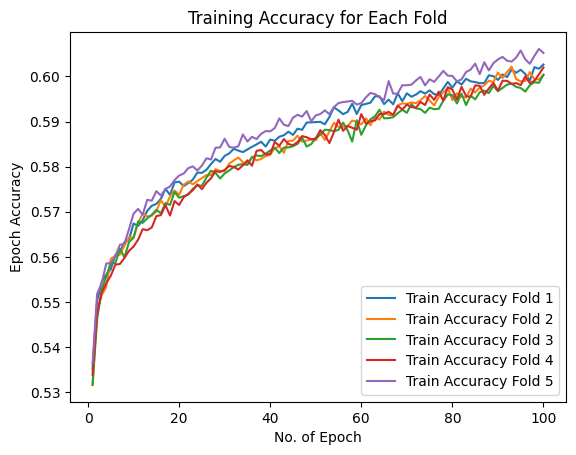

In [31]:
for fold, train_accuracies in enumerate(all_train_accuracies):
    plt.plot(range(1, num_epochs+1), train_accuracies, label=f'Train Accuracy Fold {fold+1}')

plt.title('Training Accuracy for Each Fold')
plt.xlabel('No. of Epoch')
plt.ylabel('Epoch Accuracy')
plt.legend()
plt.show()